$$Conceito:$$

**Otimização dos parametros é usado para ajustar de forma a minimizar um erro ou maximizar uma performance:
Os Principais modelos de otimizaçao dos parametros são:**

**Grid Search** = Algoritmo procura o conjunto que leva ao melhor score testanto todas as possibilidade do grid,é computacionamente o metodo mais demorado e nem sempre obtém os melhores resultados.

**Randomized Search** = Em contraste com o GridSearchCV, nem todos os valores dos parâmetros são testados, mas sim um número fixo de configurações de parâmetros é amostrado a partir das distribuições especificadas.

**Bayesian Optimization** = A Otimização Bayesiana “aprende” com cada teste feito, sendo mais eficaz na seleção da melhor combinação de hiperparâmetros.



## Objetivo: Encontrar a melhor acurácia de cada modelo através dos melhores hiperparâmetros

In [1]:
#Importar as bibliotecas
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from time import time

## Carregando o dataset

In [2]:
#Carregar dataset
dados = pd.read_csv('credit.csv',encoding='latin1',sep=',')
dados

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


Fonte: https://www.kaggle.com/laotse/credit-risk-dataset

In [3]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


**Temos 4 variaveis categoricas, para usar o algoritimo Random Forest precisamos ter todas as variáveis numericas**

In [4]:
#Transformar as variáveis object em numericas
import warnings
warnings.filterwarnings('ignore')
import category_encoders as ce

#Aplicar transformação nos dados
af = ce.OrdinalEncoder(cols=['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file'])
dados_transform = af.fit_transform(dados)
dados_transform.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  int32  
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  int32  
 5   loan_grade                  32581 non-null  int32  
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  int32  
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int32(4), int64(5)
memory usage: 2.5 MB


**Agora todas as variaveis são numericas**

In [5]:
#Verificar dados NAN
nan = dados_transform.isnull().values.sum()
print(f'Dados NaN = {nan}')

#Remover dados NaN
dados_transform1 = pd.DataFrame(dados_transform.dropna(axis=0, how='any'))
print(f'Dados NaN após transformação = {dados_transform1.isnull().values.sum()}')
print(f'Tamanho do dataset após transformação = {dados_transform1.shape}')

Dados NaN = 4011
Dados NaN após transformação = 0
Tamanho do dataset após transformação = (28638, 12)


# Modelagem: 

## DecisionTreeClassifier()

In [6]:
#Divisão dos dados em X e Y
x = dados_transform1.drop('loan_status',axis=1)
y = dados_transform1.loan_status

#Divisão entre treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=1)

In [7]:
start = time()

# Construção do Classificador
decision_tree = DecisionTreeClassifier(random_state = 1)

#Treinar o modelo com os dados de treino
decision_tree.fit(X_train, y_train)

# Score do modelo
scores = cross_val_score(decision_tree, X_train, y_train)

#Score do modelo com os dados de teste
decision_tree_score = decision_tree.score(X_test,y_test)
print(f'\nScore Teste: {round(decision_tree_score,3)*100}%')

#Tempo de execução do modelo
time1 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))


Score Teste: 88.6%

Execução em 0.54 segundos.


**Acurácia do modelo DecisionTreeClassifier sem otimização**

## Otimização dos Hiperparâmetros do Modelo DecisionTreeClassifier com Randomized Search

- **O Randomized Search gera amostras dos parâmetros dos algoritmos a partir de uma distribuição randômica uniforme para um número fixo de interações. Um modelo é construído e testado para cada combinação de parâmetros**

In [8]:
#Pacote RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [9]:
start = time()

# Definição dos parâmetros
param_dist = {"max_depth": [0,1,2,4,5,7,8,10,20],"min_samples_split": [0,1,2,4,5,7,8,10,20],
              "min_samples_leaf": [0,1,2,4,5,7,8,10,20],"criterion":['gini','entropy'],
               "max_features": [0,1,2,4,5,7,8,10,20]}

# Construção do Classificador
TreeClas_model = DecisionTreeClassifier(random_state = 1)

# Usar o modelo DecisionTreeClassifier para otimização dos hiperparametros
TreeClas_rsearch = RandomizedSearchCV(TreeClas_model,param_distributions = param_dist,n_iter=300, random_state = 1)

# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
TreeClas_rsearch.fit(X_train, y_train)

# Imprimindo o melhor estimador
bestclf = TreeClas_rsearch.best_estimator_
print (f'              **Melhores parametros com rsearch**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
TreeClas_rsearch_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(TreeClas_rsearch_acuracy,2)*100}%')

#Tempo de execução do modelo
time2 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))

              **Melhores parametros com rsearch**

DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=8,
                       min_samples_leaf=4, min_samples_split=10,
                       random_state=1)


Acurácia: 93.0%

Execução em 21.84 segundos.


**Acurácia do modelo DecisionTreeClassifier com otimização dos hiperparâmetros com Randomized Search**

## Otimização dos Hiperparâmetros do DecisionTreeClassifier com Grid Search

- **O Grid Search realiza metodicamente combinações entre todos os parâmetros do algoritmo, criando um grid, não necessitando do parâmetro 'n_iter'** 

In [10]:
#Pacote GridSearchCV
from sklearn.model_selection import GridSearchCV

In [11]:
start = time()

# Definição dos parâmetros
param_dist = {"max_depth": [0,2,5,8,10],
              "min_samples_split": [0,2,5,8,10],
              "min_samples_leaf": [0,2,5,8,10],
              "criterion":['gini','entropy'],
               "max_features": [0,2,5,8,10]}

# Construção do Classificador
TreeClas_model = DecisionTreeClassifier(random_state = 1)


# Usar o modelo DecisionTreeClassifier para otimização dos hiperparametros
TreeClas_gsearch = GridSearchCV(TreeClas_model,param_grid = param_dist)

# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
TreeClas_gsearch.fit(X_train, y_train)

# Imprimindo o melhor estimador
bestclf = TreeClas_gsearch.best_estimator_
print (f'              **Melhores parametros com rsearch**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
TreeClas_gsearch_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(TreeClas_gsearch_acuracy,3)*100}%')

#Tempo de execução do modelo

#Tempo de execução do modelo
time3 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))

              **Melhores parametros com rsearch**

DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=8,
                       min_samples_leaf=2, min_samples_split=8, random_state=1)


Acurácia: 92.4%

Execução em 93.81 segundos.


## Otimização dos Hiperparâmetros do DecisionTreeClassifier com BayesSearchCV

In [12]:
#Pacote BayesSearchCV
from skopt import BayesSearchCV


In [13]:
import warnings
warnings.filterwarnings('ignore')
start = time()

# Definição dos parâmetros
param_dist = {"max_depth": [1,2,4,5,7,8,10,20],"min_samples_split": [2,4,5,7,8,10,20],
              "min_samples_leaf": [1,2,4,5,7,8,10,20],"criterion":['gini','entropy'],
               "max_features": [1,2,3,4,8,10,11]}


# Construção do Classificador
TreeClas_model = DecisionTreeClassifier(random_state = 1)

# Usar o modelo DecisionTreeClassifier para otimização dos hiperparametros
TreeClas_BayesSearchCV = BayesSearchCV(TreeClas_model,param_dist)

# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
TreeClas_BayesSearchCV.fit(X_train, y_train)

# Imprimindo o melhor estimador
bestclf = TreeClas_BayesSearchCV.best_estimator_
print (f'              **Melhores parametros com rsearch**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)


# Acurácia
TreeClas_BayesSearchCV_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(TreeClas_BayesSearchCV_acuracy,2)*100}%')

#Tempo de execução do modelo
time4 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))

              **Melhores parametros com rsearch**

DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=11,
                       min_samples_split=5, random_state=1)


Acurácia: 93.0%

Execução em 77.60 segundos.


## Comparando os 4 modelos 

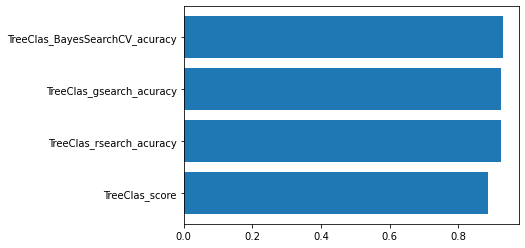

In [14]:
import matplotlib.pyplot as plt
scores = pd.DataFrame([decision_tree_score,TreeClas_rsearch_acuracy,
                       TreeClas_gsearch_acuracy,TreeClas_BayesSearchCV_acuracy])

scores['columns1'] =  ['TreeClas_score','TreeClas_rsearch_acuracy',
                       'TreeClas_gsearch_acuracy','TreeClas_BayesSearchCV_acuracy']

scores.columns = ['Scores','Modelos']

#Plotar 
plt.barh(scores.Modelos,scores['Scores']);


In [15]:
#Valor dos Scores dos modelos 
scores['Time(Seg)'] = time1,time2,time3,time4
scores

,Scores,Modelos,Time(Seg)
0,0.885940,TreeClas_score,0.536
1,0.925745,TreeClas_rsearch_acuracy,21.841
2,0.924115,TreeClas_gsearch_acuracy,93.807
3,0.929935,TreeClas_BayesSearchCV_acuracy,77.595


**Observamos que os modelos com otimização foram os que tiveram o melhor desempenho**

## Extremely Randomized Trees (ExtraTrees)

- **São criadas várias arvores com dados aleatórios, os dados existentes em cada uma destas variáveis serão separados também de maneira aleatória, para que o nó raiz varie em algumas árvores**

In [16]:
#Pacote ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [17]:
start = time()

# Construção do Classificador
ExtraTrees = ExtraTreesClassifier(min_samples_split = 2, random_state = 1)

#Treinar o modelo com os dados de treino
ExtraTrees.fit(X_train, y_train)

#Score do modelo com os dados de teste
ExtraTrees_score = ExtraTrees.score(X_test,y_test)
print(f'\nScore Teste: {round(ExtraTrees_score,2)*100}%')

#Tempo de execução do modelo
time1 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))


Score Teste: 92.0%

Execução em 1.43 segundos.


**Acurácia do modelo ExtraTreesClassifier sem otimização**

## Otimização dos Hiperparâmetros do ExtraTrees com Randomized Search

In [18]:
start = time()

# Definição dos parâmetros

param_dist = {"max_depth": [1, 3, 7, 8],
              "max_features": [2,4,5,7,8],
              "min_samples_split": [3,4,5,7,10],
              "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7],
              "bootstrap": [True, False],
              "criterion": ['gini','entropy']}


# Construção do Classificador
ExtraTrees = ExtraTreesClassifier(random_state = 1)


# Usar o modelo ExtraTreesClassifier para otimização dos hiperparametros
ExtraTrees_rsearch = RandomizedSearchCV(ExtraTrees,param_distributions = param_dist,n_iter=100,random_state = 1)

# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
ExtraTrees_rsearch.fit(X_train, y_train)


# Imprimindo o melhor estimador
bestclf = ExtraTrees_rsearch.best_estimator_
print (f'              **Melhores parametros com rsearch**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
ExtraTrees_rsearch_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(ExtraTrees_rsearch_acuracy,2)*100}%')

#Tempo de execução do modelo
time2 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))

              **Melhores parametros com rsearch**

ExtraTreesClassifier(criterion='entropy', max_depth=8, max_features=8,
                     min_samples_leaf=2, min_samples_split=3, random_state=1)


Acurácia: 92.0%

Execução em 237.12 segundos.


## Otimização dos Hiperparâmetros do ExtraTrees com Grid Search

In [19]:
start = time()
# Definição dos parâmetros

param_dist = {"max_depth": [ 7, 8],
              "max_features": [8,10],
              "min_samples_split": [7,10],
              "min_samples_leaf": [8,10],
              "bootstrap": [True, False],
              "criterion": ['gini']}


# Construção do Classificador
ExtraTrees = ExtraTreesClassifier(random_state = 1)


# Usar o modelo ExtraTreesClassifier para otimização dos hiperparametros
ExtraTrees_gsearch = GridSearchCV(ExtraTrees,param_grid = param_dist)

# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
ExtraTrees_gsearch.fit(X_train, y_train)

# Imprimindo o melhor estimador
bestclf = ExtraTrees_gsearch.best_estimator_
print (f'              **Melhores parametros com rsearch**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
ExtraTrees_gsearch_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(ExtraTrees_gsearch_acuracy,2)*100}%')

#Tempo de execução do modelo
time3 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))

              **Melhores parametros com rsearch**

ExtraTreesClassifier(max_depth=8, max_features=10, min_samples_leaf=8,
                     min_samples_split=7, random_state=1)


Acurácia: 92.0%

Execução em 121.64 segundos.


## Otimização dos Hiperparâmetros do ExtraTrees com BayesSearchCV

In [20]:
import warnings
warnings.filterwarnings('ignore')
start = time()
# Definição dos parâmetros

param_dist = {"max_depth": [1, 3, 7, 8],
              "max_features": [2,4,5,7,8],
              "min_samples_split": [3,4,5,7,10],
              "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7],
              "bootstrap": [True, False],
              "criterion": ['gini','entropy']}


# Construção do Classificador
ExtraTrees_mpdel = ExtraTreesClassifier(random_state = 1)


# Usar o modelo Bagging para otimização dos hiperparametros
ExtraTrees_BayesSearch = BayesSearchCV(ExtraTrees_mpdel,param_dist)

# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
ExtraTrees_BayesSearch.fit(X_train, y_train)

# Imprimindo o melhor estimador
bestclf = ExtraTrees_BayesSearch.best_estimator_
print (f'              **Melhores parametros com rsearch**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
ExtraTrees_BayesSearch_acuracy = accuracy_score(y_test, y_pred)

print(ExtraTrees_BayesSearch_acuracy)

#Tempo de execução do modelo
time4 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))

              **Melhores parametros com rsearch**

ExtraTreesClassifier(max_depth=8, max_features=8, min_samples_split=5,
                     random_state=1)

0.9137569832402235

Execução em 266.13 segundos.


## Comparando os 4 modelos com ExtraTrees

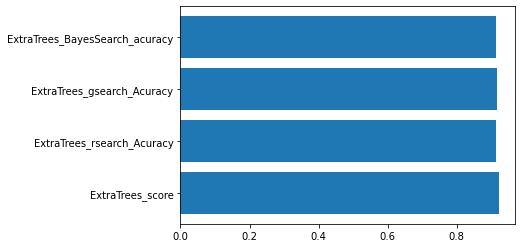

In [21]:
#Modelos
scores = pd.DataFrame([ExtraTrees_score,ExtraTrees_rsearch_acuracy,
                       ExtraTrees_gsearch_acuracy,ExtraTrees_BayesSearch_acuracy])

scores['columns1'] =  ['ExtraTrees_score','ExtraTrees_rsearch_Acuracy',
                       'ExtraTrees_gsearch_Acuracy','ExtraTrees_BayesSearch_acuracy']

scores.columns = ['Scores','Modelos']

#Plotar 
plt.barh(scores.Modelos,scores['Scores']);

In [22]:
#Valor dos Scores dos modelos 
scores['Time(Seg)'] = time1,time2,time3,time4
scores

,Scores,Modelos,Time(Seg)
0,0.923301,ExtraTrees_score,1.425
1,0.915037,ExtraTrees_rsearch_Acuracy,237.124
2,0.915270,ExtraTrees_gsearch_Acuracy,121.638
3,0.913757,ExtraTrees_BayesSearch_acuracy,266.126


**O Modelo ExtraTrees com GridSearch é o algoritimo que requer mais poder computacional, testando todas as possibilidades, portanto diminuimos o numeros de parametros, já o modelo sem otimização já obteve otimos resultados com poucos segundos de treinamento**

## Adaboost

 - **O Modelo começa ajustando um classificador no conjunto de dados original e depois ajusta cópias adicionais do classificador no mesmo conjunto de dados, mas onde os pesos das instâncias classificadas incorretamente são ajustados (Underfitting) para que os classificadores subsequentes se concentrem mais em casos difíceis**

In [23]:
#Pacote AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

In [24]:
start = time()

# Construção do Classificador
AdaBoost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(), 
                                learning_rate = 0.1, 
                                n_estimators = 400, 
                                algorithm = "SAMME",
                                random_state=1)

#Treinar o modelo com os dados de treino
AdaBoost.fit(X_train, y_train)

#Score do modelo com os dados de teste
AdaBoost_score= AdaBoost.score(X_test,y_test)
print(f'\nScore Teste: {round(AdaBoost_score,2)*100}%')

#Tempo de execução do modelo
time1 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))


Score Teste: 88.0%

Execução em 0.13 segundos.


## Otimização dos Hiperparâmetros do Adaboost com Randomized Search

In [25]:
start = time()

# Definição dos parâmetros

param_dist = {"learning_rate": [0.0000000001,0.0001,0.01,0.1,1.0,3.0],
              "n_estimators": [50,100,200,4000],
              "algorithm": ['SAMME', 'SAMME.R'],
              "n_estimators": [100] }

# Construção do Classificador
AdaBoost = AdaBoostClassifier(random_state=1)
    

# Usar o modelo Adaboost para otimização dos hiperparametros
Adaboost_rsearch = RandomizedSearchCV(AdaBoost,param_distributions = param_dist,n_iter=10, random_state = 1)


# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
Adaboost_rsearch.fit(X_train, y_train)

# Imprimindo o melhor estimador
bestclf = Adaboost_rsearch.best_estimator_
print (f'              **Melhores parametros com rsearch**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
Adaboost_rsearch_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(Adaboost_rsearch_acuracy,2)*100}%')

#Tempo de execução do modelo
time2 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))

              **Melhores parametros com rsearch**

AdaBoostClassifier(n_estimators=100, random_state=1)


Acurácia: 88.0%

Execução em 50.17 segundos.


## Otimização dos Hiperparâmetros do Adaboost com Grid Search

In [26]:
start = time()

# Definição dos parâmetros
param_dist = {"learning_rate": [0.0001,0.01,0.1,1.0,3.0],
              "n_estimators": [100],
              "algorithm": ['SAMME', 'SAMME.R']}

# Construção do Classificador
AdaBoost = AdaBoostClassifier(random_state=1)

# Usar o modelo Bagging para otimização dos hiperparametros
Adaboost_gsearch = GridSearchCV(AdaBoost,param_grid = param_dist)

# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
Adaboost_gsearch.fit(X_train, y_train)

# Imprimindo o melhor estimador
bestclf = Adaboost_gsearch.best_estimator_
print (f'              **Melhores parametros com rsearch**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
Adaboost_gsearch_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(Adaboost_gsearch_acuracy,2)*100}%')

#Tempo de execução do modelo
time3 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))

              **Melhores parametros com rsearch**

AdaBoostClassifier(n_estimators=100, random_state=1)


Acurácia: 88.0%

Execução em 49.13 segundos.


## Otimização dos Hiperparâmetros do AdaBoost com BayesSearchCV

In [27]:
import warnings
warnings.filterwarnings('ignore')
start = time()

# Definição dos parâmetros

param_dist = {"learning_rate": [0.0001,0.01,0.1,1.0],
              "n_estimators": [40],
              "algorithm": ['SAMME', 'SAMME.R']}

# Construção do Classificador
AdaBoost = AdaBoostClassifier(random_state=1)

# Usar o modelo Bagging para otimização dos hiperparametros
AdaBoost_BayesSearch = BayesSearchCV(AdaBoost,param_dist)

# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
AdaBoost_BayesSearch.fit(X_train, y_train)

# Imprimindo o melhor estimador
bestclf = AdaBoost_BayesSearch.best_estimator_
print (f'              **Melhores parametros com rsearch**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
AdaBoost_BayesSearch_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(AdaBoost_BayesSearch_acuracy,2)*100}%')

#Tempo de execução do modelo
time4 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))

              **Melhores parametros com rsearch**

AdaBoostClassifier(n_estimators=40, random_state=1)


Acurácia: 88.0%

Execução em 168.13 segundos.


## Comparando os 4 modelos com AdaBoost

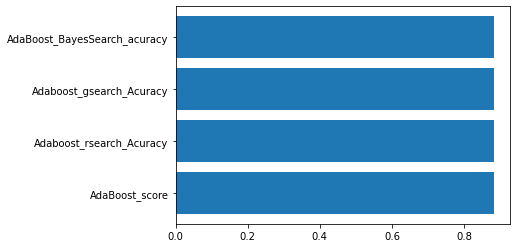

In [28]:
## Comparando os 3 modelos com ExtraTrees#Modelos
scores = pd.DataFrame([AdaBoost_score,Adaboost_rsearch_acuracy,
                       Adaboost_gsearch_acuracy,AdaBoost_BayesSearch_acuracy])

scores['columns1'] =  ['AdaBoost_score','Adaboost_rsearch_Acuracy',
                       'Adaboost_gsearch_Acuracy','AdaBoost_BayesSearch_acuracy']

scores.columns = ['Scores','Modelos']

#Plotar 
plt.barh(scores.Modelos,scores['Scores']);

In [29]:
#Valor dos Scores dos modelos 
scores['Time(Seg)'] = time1,time2,time3,time4
scores

,Scores,Modelos,Time(Seg)
0,0.883962,AdaBoost_score,0.129
1,0.884078,Adaboost_rsearch_Acuracy,50.170
2,0.884078,Adaboost_gsearch_Acuracy,49.133
3,0.882682,AdaBoost_BayesSearch_acuracy,168.129


**Não há diferença em nenhum dos modelos, independente da otimização**

## Gradient Boosting

- **Cada nova árvore é um ajuste em uma versão modificada do conjunto de dados original.O objetivo do algoritmo é criar uma corrente de modelos fracos, onde cada um tem como objetivo minimizar o erro do modelo anterior, por meio de uma função de perda**

In [30]:
#Pacote GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [31]:
start = time()

# Construção do Classificador
GradientBoosting = GradientBoostingClassifier(min_samples_split = 2, random_state = 1)

#Treinar o modelo com os dados de treino
GradientBoosting.fit(X_train, y_train)

#Score do modelo com os dados de teste
GradientBoosting_score= GradientBoosting.score(X_test,y_test)
print(f'\nScore Teste: {round(GradientBoosting_score,2)*100}%')

#Tempo de execução do modelo
time1 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))


Score Teste: 92.0%

Execução em 1.98 segundos.


## Otimização dos Hiperparâmetros do Gradient Boosting com Randomized Search

In [32]:
start = time()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Definição dos parâmetros

param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [3, 6,8],
              'min_samples_leaf': [3, 5],
              'subsample': [0.3, 0.5, 0.7],
              'n_estimators': [60],
              'loss': ['deviance', 'exponential'],
              'criterion' : [ 'squared_error', 'mse']}

# Construção do Classificador
GradientBoosting = GradientBoostingClassifier()


# Modelo criado com GridSearchCV
GradientBoosting_rsearch = RandomizedSearchCV(GradientBoosting, param_grid).fit(X_train, y_train)


# Imprimindo o melhor estimador
bestclf = GradientBoosting_rsearch.best_estimator_
print (f'              **Melhores parametros com rsearch**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
GradientBoosting_rsearch_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(GradientBoosting_rsearch_acuracy,2)*100}%')

#Tempo de execução do modelo
time2 = round((time() - start),3)
print("\nExecução em %.2f segunds." 
      % ((time() - start)))

              **Melhores parametros com rsearch**

GradientBoostingClassifier(criterion='mse', max_depth=6, min_samples_leaf=3,
                           n_estimators=60, subsample=0.3)


Acurácia: 93.0%

Execução em 69.19 segunds.


## Otimização dos Hiperparâmetros do Gradient Boosting com GridSearchCV

In [33]:
start = time()
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Grid de parâmetros
param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [3, 6,8],
              'min_samples_leaf': [3, 5],
              'subsample': [0.3, 0.5, 0.7],
              'n_estimators': [40]
              }

# Classifier
GradientBoosting_grid = GradientBoostingClassifier()

# Modelo criado com GridSearchCV
GradientBoosting_grid = GridSearchCV(GradientBoosting_grid, param_grid).fit(X_train, y_train)

# Imprimindo o melhor estimador
bestclf = GradientBoosting_grid.best_estimator_
print (f'              **Melhores parametros com rsearch**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
GradientBoosting_grid_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(GradientBoosting_grid_acuracy,2)*100}%')

#Tempo de execução do modelo
time3 = round((time() - start),3)
print("\nExecução em %.2f segunds." 
      % ((time() - start)))

              **Melhores parametros com rsearch**

GradientBoostingClassifier(max_depth=6, min_samples_leaf=5, n_estimators=40,
                           subsample=0.7)


Acurácia: 93.0%

Execução em 223.53 segunds.


## Otimização dos Hiperparâmetros do GradientBoosting com BayesSearchCV

In [34]:
import warnings
warnings.filterwarnings('ignore')
start = time()
# Definição dos parâmetros

# Grid de parâmetros
param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [3, 6,8],
              'min_samples_leaf': [3, 5],
              'subsample': [0.3, 0.5, 0.7],
              'n_estimators': [40]
              }


# Classifier
GradientBoosting_BayesSearch = GradientBoostingClassifier()

# Usar o modelo Bagging para otimização dos hiperparametros
GradientBoosting_BayesSearch = BayesSearchCV(GradientBoosting_BayesSearch,param_grid)

# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
GradientBoosting_BayesSearch.fit(X_train, y_train)

# Imprimindo o melhor estimador
bestclf = GradientBoosting_BayesSearch.best_estimator_
print (f'              **Melhores parametros com rsearch**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
GradientBoosting_BayesSearch_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(GradientBoosting_BayesSearch_acuracy,2)*100}%')

#Tempo de execução do modelo
time4 = round((time() - start),3)
print("\nExecução em %.2f segunds." 
      % ((time() - start)))

              **Melhores parametros com rsearch**

GradientBoostingClassifier(max_depth=8, min_samples_leaf=3, n_estimators=40,
                           subsample=0.7)


Acurácia: 93.0%

Execução em 391.60 segunds.


## Comparando os 4 modelos com GradientBoosting

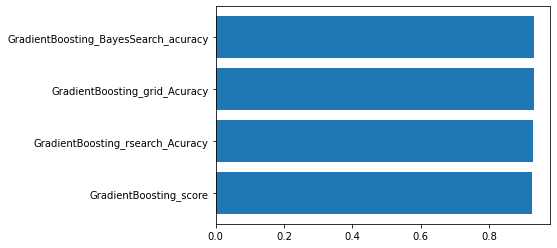

In [35]:
## Comparando os 3 modelos 
scores = pd.DataFrame([GradientBoosting_score,GradientBoosting_rsearch_acuracy,
                       GradientBoosting_grid_acuracy,GradientBoosting_BayesSearch_acuracy])

scores['columns1'] =  ['GradientBoosting_score','GradientBoosting_rsearch_Acuracy',
                       'GradientBoosting_grid_Acuracy','GradientBoosting_BayesSearch_acuracy']

scores.columns = ['Scores','Modelos']

#Plotar 
plt.barh(scores.Modelos,scores['Scores']);

In [36]:
#Valor dos Scores dos modelos 
scores['Time(Seg)'] = time1,time2,time3,time4
scores

,Scores,Modelos,Time(Seg)
0,0.923999,GradientBoosting_score,1.985
1,0.929353,GradientBoosting_rsearch_Acuracy,69.191
2,0.929818,GradientBoosting_grid_Acuracy,223.525
3,0.932263,GradientBoosting_BayesSearch_acuracy,391.603


**Note que todos os modelos que foram otimizados, tiveram praticamente a mesma acuracia**

## XGBClassifier

- **É uma melhora do Gradient Boosting pois possui mais parâmetros e é otimizada tanto para eficiência de memória quanto para velocidade de treinamento**

In [37]:
#Pacote XGBClassifier
from xgboost import XGBClassifier

In [38]:
start = time()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Construção do Classificador
Model_XGBClassifier= XGBClassifier(min_samples_split = 2,learning_rate=0.1, max_depth=8,random_state = 1,verbosity=0)

#Treinar o modelo com os dados de treino
Model_XGBClassifier.fit(X_train, y_train)

#Score do modelo com os dados de teste
Model_XGBClassifier_score= Model_XGBClassifier.score(X_test,y_test)
print(f'\nScore Teste: {round(Model_XGBClassifier_score,2)*100}%')

#Tempo de execução do modelo
time1 = round((time() - start),3)
print("\nExecução em %.2f segundos." 
      % ((time() - start)))


Score Teste: 94.0%

Execução em 1.59 segundos.


## Otimização dos Hiperparâmetros do XGBoosting com Randomized Search

In [39]:
start = time()
import warnings
warnings.filterwarnings('ignore')

# Definição dos parâmetros

# Grid de parâmetros
param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [3, 6,8],
              'min_samples_leaf': [3, 5],
              'subsample': [0.3, 0.5, 0.7],
              'n_estimators': [100]}


# Construção do Classificador
XGBClassifier_rsearch= XGBClassifier(random_state = 1,verbosity= 0)


# Modelo criado com GridSearchCV
XGBClassifier_rsearch = RandomizedSearchCV(XGBClassifier_rsearch, param_grid).fit(X_train, y_train)


# Imprimindo o melhor estimador
bestclf = XGBClassifier_rsearch.best_estimator_
print (f'              **Melhores parametros com rsearch**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
XGBClassifier_rsearch_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(XGBClassifier_rsearch_acuracy,2)*100}%')

#Tempo de execução do modelo
time2 = round((time() - start),3)
print("\nExecução em %.2f segunds." 
      % ((time() - start)))

              **Melhores parametros com rsearch**

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, min_samples_leaf=3, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=0)


Acurácia: 93.0%

Execução em 65.26 segunds.


## Otimização dos Hiperparâmetros do XGBoosting com GridSearchCV

In [40]:
start = time()
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Grid de parâmetros
param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [3, 6,8],
              'min_samples_leaf': [3, 5],
              'subsample': [0.5],
              'n_estimators': [40]
              }

# Construção do Classificador
XGBClassifier_gsearch= XGBClassifier(random_state = 1,verbosity = 0)

# Modelo criado com GridSearchCV
XGBClassifier_gsearch = GridSearchCV(XGBClassifier_gsearch, param_grid).fit(X_train, y_train)

# Imprimindo o melhor estimador
bestclf = XGBClassifier_gsearch.best_estimator_
print (f'              **Melhores parametros com rsearch**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
XGBClassifier_gsearch_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(XGBClassifier_gsearch_acuracy,2)*100}%')

#Tempo de execução do modelo
time3 = round((time() - start),3)
print("\nExecução em %.2f segunds." 
      % ((time() - start)))

              **Melhores parametros com rsearch**

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=8, min_child_weight=1, min_samples_leaf=3, missing=nan,
              monotone_constraints='()', n_estimators=40, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=0)


Acurácia: 93.0%

Execução em 58.65 segunds.


## Otimização dos Hiperparâmetros do XGBClassifier com BayesSearchCV

In [41]:
start = time()
# Definição dos parâmetros

# Grid de parâmetros
param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [3, 6,8],
              'min_samples_leaf': [3, 5],
              'subsample': [0.5],
              'n_estimators': [40]
              }


# Construção do Classificador
XGBClassifier_BayesSearch= XGBClassifier(random_state = 1,verbosity = 0)

# Usar o modelo Bagging para otimização dos hiperparametros
XGBClassifier_BayesSearch = BayesSearchCV(XGBClassifier_BayesSearch,param_grid)

# Aplicando o resultado ao conjunto de dados de treino e obtendo o score
XGBClassifier_BayesSearch.fit(X_train, y_train)

# Imprimindo o melhor estimador
bestclf = XGBClassifier_BayesSearch.best_estimator_
print (f'              **Melhores parametros com rsearch**')
print (f'\n{bestclf}\n')

# Aplicando o melhor estimador para realizar as previsões
y_pred = bestclf.predict(X_test)

# Acurácia
XGBClassifier_BayesSearch_acuracy = accuracy_score(y_test, y_pred)

print(f'\nAcurácia: {round(XGBClassifier_BayesSearch_acuracy,2)*100}%')

#Tempo de execução do modelo
time4 = round((time() - start),3)
print("\nExecução em %.2f segunds." 
      % ((time() - start)))

              **Melhores parametros com rsearch**

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=8, min_child_weight=1, min_samples_leaf=3, missing=nan,
              monotone_constraints='()', n_estimators=40, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=0)


Acurácia: 93.0%

Execução em 202.18 segunds.


## Comparando os 4 modelos com XGBClassifier

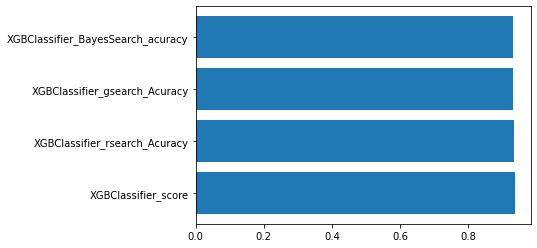

In [42]:
## Comparando os 4 modelos 
scores = pd.DataFrame([Model_XGBClassifier_score,XGBClassifier_rsearch_acuracy,
                       XGBClassifier_gsearch_acuracy,XGBClassifier_BayesSearch_acuracy])

scores['columns1'] =  ['XGBClassifier_score','XGBClassifier_rsearch_Acuracy',
                       'XGBClassifier_gsearch_Acuracy','XGBClassifier_BayesSearch_acuracy']

scores.columns = ['Scores','Modelos']

#Plotar 
plt.barh(scores.Modelos,scores['Scores']);

In [43]:
#Valor dos Scores dos modelos 
scores['Time(Seg)'] = time1,time2,time3,time4
scores

,Scores,Modelos,Time(Seg)
0,0.936220,XGBClassifier_score,1.591
1,0.934474,XGBClassifier_rsearch_Acuracy,65.261
2,0.932263,XGBClassifier_gsearch_Acuracy,58.653
3,0.932263,XGBClassifier_BayesSearch_acuracy,202.180


**Praticamente não há diferença entre os algoritimos XGBoost e seus otimizadores**

# Comparar os modelos sem otimização

### Grafico dos Scores sem Otimização

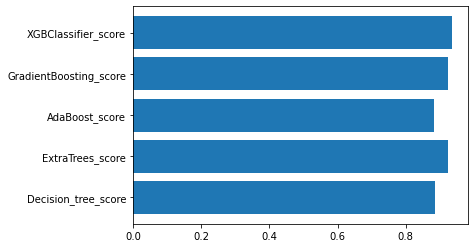

In [44]:
#Grafico dos Scores sem Otimização
import matplotlib.pyplot as plt
scores = pd.DataFrame([decision_tree_score,ExtraTrees_score,AdaBoost_score,
                       GradientBoosting_score,Model_XGBClassifier_score])

scores['Modelos'] =  ['Decision_tree_score','ExtraTrees_score','AdaBoost_score',
                      'GradientBoosting_score','XGBClassifier_score']

scores.columns = ['Scores','Modelos']
#Plotar 
plt.barh(scores.Modelos,scores['Scores']);

In [45]:
#Valor dos Scores dos modelos 
scores

,Scores,Modelos
0,0.885940,Decision_tree_score
1,0.923301,ExtraTrees_score
2,0.883962,AdaBoost_score
3,0.923999,GradientBoosting_score
4,0.936220,XGBClassifier_score


**Podemos observar que o modelo que obteve o maior score foi: XGBClassifier pois ele usa muitos parametros deixando o algoritimo mais robusto em relação aos outros, já os algoritimos Decision_tree e AdaBoost foram os modelos com acuracia mais baixa**

# Comparar os modelos otimizados pelo algoritimo Randomized Search

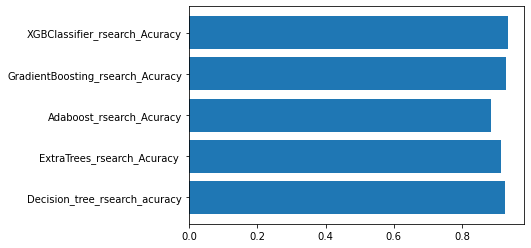

In [46]:
### Grafico dos Parametros com Randomized Search
import matplotlib.pyplot as plt

scores = pd.DataFrame([TreeClas_rsearch_acuracy,ExtraTrees_rsearch_acuracy ,
                       Adaboost_rsearch_acuracy,GradientBoosting_rsearch_acuracy,
                       XGBClassifier_rsearch_acuracy])

scores['Modelos'] =  ['Decision_tree_rsearch_acuracy','ExtraTrees_rsearch_Acuracy ',
                      'Adaboost_rsearch_Acuracy','GradientBoosting_rsearch_Acuracy',
                      'XGBClassifier_rsearch_Acuracy']

scores.columns = ['Scores','Modelos']

#Plotar 
plt.barh(scores.Modelos,scores['Scores']);

In [47]:
#Valor dos Scores dos modelos 
scores

,Scores,Modelos
0,0.925745,Decision_tree_rsearch_acuracy
1,0.915037,ExtraTrees_rsearch_Acuracy
2,0.884078,Adaboost_rsearch_Acuracy
3,0.929353,GradientBoosting_rsearch_Acuracy
4,0.934474,XGBClassifier_rsearch_Acuracy


**Os modelos que tiveram melhor acuracia foram: GradientBoosting_rsearch e  XGBClassifier_rsearch, já o modelo Adaboost_rsearch foi o que obteve a pior acuracia**

# Comparar os modelos otimizados pelo algoritimo Grid Search

<BarContainer object of 5 artists>

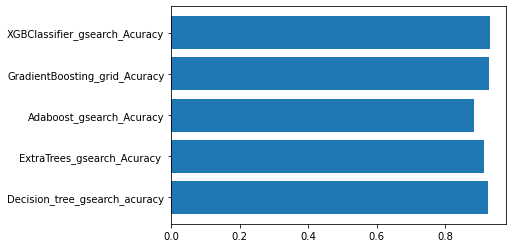

In [48]:
scores = pd.DataFrame([TreeClas_gsearch_acuracy,ExtraTrees_gsearch_acuracy ,
                       Adaboost_gsearch_acuracy,GradientBoosting_grid_acuracy,
                       XGBClassifier_gsearch_acuracy])

scores['Modelos'] =  ['Decision_tree_gsearch_acuracy','ExtraTrees_gsearch_Acuracy ',
                      'Adaboost_gsearch_Acuracy','GradientBoosting_grid_Acuracy',
                      'XGBClassifier_gsearch_Acuracy']

scores.columns = ['Scores','Modelos']

#Plotar 
plt.barh(scores.Modelos,scores['Scores'])

In [49]:
#Valor dos Scores dos modelos 
scores

,Scores,Modelos
0,0.924115,Decision_tree_gsearch_acuracy
1,0.915270,ExtraTrees_gsearch_Acuracy
2,0.884078,Adaboost_gsearch_Acuracy
3,0.929818,GradientBoosting_grid_Acuracy
4,0.932263,XGBClassifier_gsearch_Acuracy


**Novamente os modelos que tiveram melhor acuracia foram: GradientBoosting_rsearch e  XGBClassifier_rsearch, já o modelo Adaboost_rsearch foi o que obteve a pior acuracia**

# Comparar os modelos otimizados pelo algoritimo Bayesian Optimization

<BarContainer object of 5 artists>

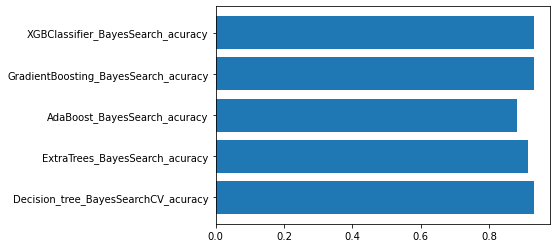

In [50]:
#Grafico dos Parametros com Bayesian Optimization

scores = pd.DataFrame([TreeClas_BayesSearchCV_acuracy,ExtraTrees_BayesSearch_acuracy,
                       AdaBoost_BayesSearch_acuracy,GradientBoosting_BayesSearch_acuracy,
                       XGBClassifier_BayesSearch_acuracy])

scores['Modelos'] =  ['Decision_tree_BayesSearchCV_acuracy','ExtraTrees_BayesSearch_acuracy',
                      'AdaBoost_BayesSearch_acuracy','GradientBoosting_BayesSearch_acuracy',
                      'XGBClassifier_BayesSearch_acuracy']

scores.columns = ['Scores','Modelos']

#Plotar 
plt.barh(scores.Modelos,scores['Scores'])

In [51]:
#Valor dos Scores dos modelos 
scores

,Scores,Modelos
0,0.929935,Decision_tree_BayesSearchCV_acuracy
1,0.913757,ExtraTrees_BayesSearch_acuracy
2,0.882682,AdaBoost_BayesSearch_acuracy
3,0.932263,GradientBoosting_BayesSearch_acuracy
4,0.932263,XGBClassifier_BayesSearch_acuracy


**Assim como com os otimizadores Bayesian Optimization e  Grid Search os modelos que tiveram melhor acuracia foram: GradientBoosting_rsearch e  XGBClassifier_rsearch, já o modelo Adaboost_rsearch foi o que obteve a pior acuracia**

# Conclusão:

**Conclusão_1: Os Melhores modelos do metodo ensamble foi com os algoritimos GradientBoosting e XGBClassifier**

**Conclusão_2: Os modelos Ensamble tem varios parametros que podem ser otimizados ainda mais ,conseguindo chegar a uma acuracia melhor**

**Conclusão_3: Os Algoritimos GridSearch e o BayesSearch tem um processo computacional exaustivo, dependendo do conjunto de dados pode demorar horas ou dias para concluir o processo, o algoritimo Randomized Search pode ser uma alternativa já que ele nao testa todos os parametros que foram passados e sim faz iterações randomizadas com os parametros e com isso não tem um peso computacional grande , e podemos observar que seu resultado é parecido com os algoritimos de melhor performance**